# Text Analytics - MsC Data Science (part time) 24' | 6th Assignement - 2nd ex.


## Part of speech tagger | Transformers

In [ ]:
import os
import pyconll
from transformers import AutoModelForMaskedLM
import torch
from transformers import DataCollatorForTokenClassification
from datasets import concatenate_datasets
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

print(torch.__version__)

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print(IN_COLAB)


greek_pretrained_model_path = 'wiki.el.bin'
if IN_COLAB:
    !apt-get install wget
    !wget -O ud-treebanks-v2.13.tgz https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-5287/ud-treebanks-v2.13.tgz?sequence=1&isAllowed=y
    !tar -xvf  'ud-treebanks-v2.13.tgz'
    local_dir = 'ud-treebanks-v2.13/UD_Greek-GUD/el_gud-ud-train.conllu'

    !wget -O wiki.el.zip https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.el.zip
    # Unzip the file
    import zipfile
    with zipfile.ZipFile("wiki.el.zip", 'r') as zip_ref:
      zip_ref.extractall("/content/")
else:

    local_dir = os.getcwd() + '//data//UD_Greek-GUD//el_gud-ud-train.conllu'

print(local_dir)

2.2.1+cu121
False
C:\Users\jason\Documents\coding_repos\aueb_ds_24_text_analytics\assignment 6//data//UD_Greek-GUD//el_gud-ud-train.conllu


In [ ]:
# Step 1: Read CoNLL-U formatted file
def read_dataset(file_path, limit_sentences=None) -> list:
    """Read a CoNLL-U formatted file and return a list of sentences, where each sentence is a list of words.
    :param file_path: path to the CoNLL-U formatted file
    :param limit_sentences: limit the number of sentences to read (useful for debugging)
    :return: list of sentences, where each sentence is a list of words"""
    # Loading the file
    data = pyconll.load_from_file(file_path)
    sentences = []

    data_to_load = data[0:limit_sentences] if limit_sentences is not None else data
    # Iterating over each sentence
    for sentence in data_to_load:
        # Spliting the sentence to words
        words = [token.form for token in sentence]

        # Retrieving the POS of each words (Y)
        tags = [token.upos for token in sentence]

        # Saving for each data point of the dataset
        sentences.append({'words': words, 'tags': tags})
    return sentences

### Loading the dataset as with previous excersises

In [ ]:
local_dir = r'C:\Users\jason\Documents\coding_repos\aueb_ds_24_text_analytics\assignment_2\data\UD_Greek-GUD\el_gud-ud-train.conllu'
# Step 1: Read data
data = read_dataset(local_dir)
print(len(data))
data

1071


[{'words': ['Τον',
   'διαβεβαιώνω',
   'ότι',
   'δεν',
   'πρόκειται',
   'να',
   'δημοσιοποιηθεί',
   'από',
   'τη',
   'δική',
   'μας',
   'υπηρεσία',
   'και',
   'κλείνουμε',
   '.'],
  'tags': ['PRON',
   'VERB',
   'SCONJ',
   'PART',
   'VERB',
   'SCONJ',
   'VERB',
   'ADP',
   'DET',
   'ADJ',
   'PRON',
   'NOUN',
   'CCONJ',
   'VERB',
   'PUNCT']},
 {'words': ['Τη', 'ρωτάω', 'πάλι', '.'],
  'tags': ['PRON', 'VERB', 'ADV', 'PUNCT']},
 {'words': ['Όσο',
   'και',
   'αν',
   'χαίρομαι',
   'που',
   'βλέπω',
   'την',
   'κόρη',
   'μου',
   'με',
   'τον',
   'Φάνη',
   'και',
   'τη',
   'Μάνια',
   'με',
   'τον',
   'Ούλι',
   ',',
   'η',
   'πρώτη',
   'μου',
   'αντίδραση',
   'είναι',
   'να',
   'τους',
   'πω',
   '«',
   'καληνύχτα',
   '»',
   'και',
   'να',
   'πάω',
   'για',
   'ύπνο',
   '.'],
  'tags': ['ADV',
   'CCONJ',
   'SCONJ',
   'VERB',
   'SCONJ',
   'VERB',
   'DET',
   'NOUN',
   'PRON',
   'ADP',
   'DET',
   'PROPN',
   'CCONJ',
   'DET',


### Since the selected language is Greek, we decided to use a Greek pre-trained model, the GreekBERT.
[https://huggingface.co/nlpaueb/bert-base-greek-uncased-v1](https://huggingface.co/nlpaueb/bert-base-greek-uncased-v1)


In [ ]:
model_dir = r'C:\\Users\\jason\\Documents\\coding_repos\\bert-base-greek-uncased-v1'
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMaskedLM.from_pretrained(model_dir)

# Example Greek sentence with a masked token
sentence = "Η Ελλάδα είναι μια [MASK] χώρα."
print('Original sentence: ', sentence)
# Tokenize the input
inputs = tokenizer(sentence, return_tensors="pt")

print('inputs: ', inputs)
print('tokens: ', tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist()))

# Get model predictions
with torch.no_grad():
    outputs = model(**inputs)

# Get the index of the masked token
masked_index = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

# Get the logits for the masked token
masked_logits = outputs.logits[0, masked_index, :]

# Get the top 5 predictions for the masked token
top_k = 5
top_k_indices = torch.topk(masked_logits, top_k, dim=1).indices[0].tolist()

# Decode the predictions
predicted_tokens = tokenizer.convert_ids_to_tokens(top_k_indices)

print(f"Sentence: {sentence}")
print(f"Top {top_k} predictions for the masked token:")
for i, token in enumerate(predicted_tokens):
    print(f"{i+1}: {token}")

# Example output:
# Sentence: Η Ελλάδα είναι μια [MASK] χώρα.
# Top 5 predictions for the masked token:
# 1: όμορφη
# 2: μεγάλη
# 3: ισχυρή
# 4: μικρή
# 5: ενδιαφέρουσα

Original sentence:  Η Ελλάδα είναι μια [MASK] χώρα.
inputs:  {'input_ids': tensor([[101, 239, 436, 357, 369, 103, 510, 121, 102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tokens:  ['[CLS]', 'η', 'ελλαδα', 'ειναι', 'μια', '[MASK]', 'χωρα', '.', '[SEP]']
Sentence: Η Ελλάδα είναι μια [MASK] χώρα.
Top 5 predictions for the masked token:
1: μεγαλη
2: μικρη
3: ισχυρη
4: ομορφη
5: νεα


### Locating the distinct Part of Speech (POS) tags

In [ ]:
merged_tags = [tag for sublist in [x['tags'] for x in data] for tag in sublist]
merged_tags = list(set(merged_tags))

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numerical labels
numerical_labels = label_encoder.fit_transform(merged_tags)

# Print the mapping of numerical labels to original labels
label_mapping = dict(zip(merged_tags,numerical_labels))
print(label_mapping)


{'NUM': 8, 'ADJ': 0, 'PUNCT': 12, 'ADV': 2, 'AUX': 3, 'VERB': 14, 'PRON': 10, 'SCONJ': 13, 'PART': 9, 'ADP': 1, 'DET': 5, 'X': 15, 'CCONJ': 4, 'NOUN': 7, 'INTJ': 6, 'PROPN': 11}


In [ ]:
sentences = []
tags = []

for sample in data:
    sentences.append(sample['words'])
    tags.append([label_mapping[pos] for pos in sample['tags']])

# Split data into train, validation, and test sets
train_data, eval_data = train_test_split(data, test_size=0.2)
validation_data, test_data = train_test_split(eval_data, test_size=0.5)

# Construct Datasets
train_dataset = Dataset.from_dict({
    'id': range(len(train_data)),
    'tokens': [sample['words'] for sample in train_data],
    'pos_tags': [
        [label_mapping[word_pos] for word_pos in sample['tags']]  # Corrected list comprehension
        for sample in train_data
    ]
})

validation_dataset = Dataset.from_dict({
    'id': range(len(validation_data)),
    'tokens': [sample['words'] for sample in validation_data],
    'pos_tags': [
        [label_mapping[word_pos] for word_pos in sample['tags']]  # Applying the same logic
        for sample in validation_data
    ]
})

test_dataset = Dataset.from_dict({
    'id': range(len(test_data)),
    'tokens': [sample['words'] for sample in test_data],
    'pos_tags': [
        [label_mapping[word_pos] for word_pos in sample['tags']]  # Applying the same logic
        for sample in test_data
    ]
})


# Construct DatasetDict
pos_dataset = DatasetDict({'train': train_dataset, 'validation': validation_dataset, 'test': test_dataset})
pos_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags'],
        num_rows: 856
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags'],
        num_rows: 107
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags'],
        num_rows: 108
    })
})

In [ ]:
print(pos_dataset['train']['tokens'][1], pos_dataset['train']['pos_tags'][1])
print(pos_dataset['validation']['tokens'][1], pos_dataset['validation']['pos_tags'][1])

['«', 'Πού', 'έμεναν', 'οι', 'Γεωργιανοί', ';', '»'] [12, 2, 14, 5, 0, 12, 12]
['Η', 'πρώτη', 'μου', 'σκέψη', 'είναι', 'να', 'πάρω', 'μαζί', 'μου', 'τον', 'Παπαδάκη', ',', 'επειδή', 'το', 'μυαλό', 'του', 'δουλεύει', 'καλύτερα', 'από', 'των', 'άλλων', '.'] [5, 0, 10, 7, 14, 13, 14, 2, 10, 5, 11, 12, 13, 5, 7, 10, 14, 2, 1, 5, 5, 12]


## Merging the datasets

In [ ]:
train_dataset = concatenate_datasets([pos_dataset["train"], pos_dataset["validation"]])
train_dataset

Dataset({
    features: ['id', 'tokens', 'pos_tags'],
    num_rows: 963
})

In [ ]:
pos_dataset['train']['pos_tags']

[[3,
  14,
  2,
  13,
  14,
  5,
  7,
  13,
  4,
  5,
  11,
  12,
  10,
  14,
  2,
  13,
  14,
  12,
  9,
  14,
  7,
  12],
 [12, 2, 14, 5, 0, 12, 12],
 [14,
  13,
  14,
  5,
  7,
  10,
  12,
  13,
  10,
  14,
  0,
  12,
  10,
  9,
  10,
  14,
  12,
  4,
  5,
  14,
  5,
  0,
  7,
  4,
  10,
  14,
  5,
  7,
  12],
 [12, 9, 3, 10, 14, 12, 12],
 [10, 14, 12, 2, 7, 4, 7, 12],
 [12, 9, 14, 12, 12],
 [14, 2, 10, 4, 10, 14, 2, 14, 12],
 [5, 14, 13, 14, 12],
 [12, 6, 12, 14, 0, 7, 12, 10, 14, 5, 11, 4, 10, 14, 1, 7, 5, 7, 12],
 [5,
  11,
  14,
  2,
  1,
  5,
  7,
  12,
  10,
  14,
  1,
  5,
  7,
  4,
  14,
  1,
  5,
  7,
  5,
  7,
  12,
  13,
  14,
  1,
  5,
  0,
  7,
  12,
  2,
  1,
  5,
  7,
  10,
  14,
  1,
  5,
  0,
  7,
  12],
 [12, 5, 7, 12, 12],
 [4, 14, 4, 10, 5, 7, 10, 12],
 [5,
  7,
  14,
  2,
  1,
  5,
  7,
  12,
  1,
  0,
  5,
  7,
  4,
  5,
  7,
  12,
  13,
  5,
  7,
  7,
  14,
  13,
  14,
  5,
  0,
  7,
  10,
  12],
 [14, 1, 5, 7, 10, 2, 14, 13, 14, 1, 5, 7, 10, 12, 4, 10, 14, 7,

In [ ]:
def tokenize_and_align_labels(examples) -> dict:
    """Tokenize the input sequences and align the labels with the tokenized inputs.
    :param examples: dictionary with keys "tokens" and "pos_tags"
    :return: dictionary with keys "input_ids", "attention_mask", and "labels"."""
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"pos_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_pos = pos_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/856 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/107 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

In [ ]:
tokenized_pos

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 856
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 107
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})

- **input_ids**: These are the tokenized input sequences converted into numerical IDs. BERT tokenizes input text into subword tokens, each of which corresponds to an ID in the model's vocabulary. These IDs are fed into the model as input.

- **token_type_ids**: BERT was pre-trained on two tasks: masked language modeling (MLM) and next sentence prediction (NSP). This parameter is used during training for the NSP task to differentiate between two sequences in the input. In fine-tuning and inference, this is typically set to all zeros, indicating that there's only one sequence being processed.

- **attention_mask**: This mask is used to indicate which elements in the input sequence should be attended to and which should be ignored. It has the same length as the input sequence and has a value of 1 for tokens that should be attended to and 0 for tokens that should be ignored. In this case, all tokens are attended to.

- **pos_tags**: These are the part-of-speech (POS) tags corresponding to each token in the input sequence. POS tagging is the process of assigning a grammatical category (like noun, verb, adjective, etc.) to each word in a sentence.

- **labels**: This is usually used during training for tasks like named entity recognition (NER) or part-of-speech tagging. It contains the true labels for each token in the input sequence. During training, the model's predictions are compared against these labels to calculate the loss and update the model's parameters.


In [ ]:
tokenized_pos['train'][1], tokenized_pos['train'][2]

({'id': 1,
  'tokens': ['«', 'Πού', 'έμεναν', 'οι', 'Γεωργιανοί', ';', '»'],
  'pos_tags': [12, 2, 14, 5, 0, 12, 12],
  'input_ids': [101, 222, 354, 2155, 273, 363, 3763, 2313, 144, 223, 102],
  'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [-100, 12, 2, 14, -100, 5, 0, -100, 12, 12, -100]},
 {'id': 2,
  'tokens': ['Μπορεί',
   'να',
   'είχε',
   'τα',
   'καπρίτσια',
   'του',
   ',',
   'να',
   'τους',
   'μιλούσε',
   'ελληνοαμερικάνικα',
   ',',
   'που',
   'δεν',
   'τα',
   'καταλάβαιναν',
   ',',
   'αλλά',
   'αυτοί',
   'έκαναν',
   'τα',
   'στραβά',
   'μάτια',
   'και',
   'του',
   'φιλούσαν',
   'το',
   'χέρι',
   '.'],
  'pos_tags': [14,
   13,
   14,
   5,
   7,
   10,
   12,
   13,
   10,
   14,
   0,
   12,
   10,
   9,
   10,
   14,
   12,
   4,
   5,
   14,
   5,
   0,
   7,
   4,
   10,
   14,
   5,
   7,
   12],
  'input_ids': [101,
   395,
   348,
   417,
   355,
   4177,
   27620,
   2

In [ ]:
tokenized_pos['test'][1]

{'id': 1,
 'tokens': ['Δεν',
  'μπορεί',
  'καν',
  'να',
  'φανταστεί',
  'σε',
  'πόσο',
  'σωστά',
  'χέρια',
  'έχει',
  'πέσει',
  '.'],
 'pos_tags': [9, 14, 9, 13, 14, 1, 5, 0, 7, 3, 14, 12],
 'input_ids': [101,
  366,
  395,
  1136,
  348,
  13007,
  356,
  604,
  1763,
  1043,
  377,
  3379,
  121,
  102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 9, 14, 9, 13, 14, 1, 5, 0, 7, 3, 14, 12, -100]}

In [ ]:
tokenized_train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_train_dataset

Map:   0%|          | 0/963 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 963
})

### Use DataCollator to dynamically pad sequences and make batches

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
data_collator

DataCollatorForTokenClassification(tokenizer=BertTokenizerFast(name_or_path='C:\\Users\\jason\\Documents\\coding_repos\\bert-base-greek-uncased-v1', vocab_size=35000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, p

In [ ]:
import torch.nn as nn

model = AutoModelForTokenClassification.from_pretrained(model_dir, num_labels=len(merged_tags)).to("cuda")
display(model)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at C:\\Users\\jason\\Documents\\coding_repos\\bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

### Manual Hyperparameter Tuning (since the Trainer doesn't have many options)

In [ ]:
import os
import json
import random
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

# Define early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of evaluation steps with no improvement before stopping
    early_stopping_threshold=0.01,  # Minimum change in the monitored metric to qualify as improvement
)

# Define hyperparameter configurations to test (example ranges)
learning_rates = [2e-5, 3e-5]
per_device_batch_sizes = [16, 32]

# Randomly sample hyperparameter configurations
random.seed(42)  # Set seed for reproducibility
hyperparams = [
    {"learning_rate": random.choice(learning_rates),
     "per_device_train_batch_size": random.choice(per_device_batch_sizes)}
    for _ in range(4)  # Number of configurations to sample
]

# Training arguments (common settings)
base_output_dir = './results'
num_train_epochs = 10
weight_decay = 0.01
warmup_steps = 500
eval_steps = 20
save_steps = 20
eval_strategy = "steps"
load_best_model_at_end = True
save_total_limit = 3

# List to store results
results = []

# Iterate over each hyperparameter configuration
for idx, params in enumerate(hyperparams):
    output_dir = os.path.join(base_output_dir, f"run-{idx+1}")

    # Update training arguments with current hyperparameters
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        learning_rate=params["learning_rate"],
        per_device_train_batch_size=params["per_device_train_batch_size"],
        per_device_eval_batch_size=64,
        weight_decay=weight_decay,
        logging_dir='./logs',
        warmup_steps=warmup_steps,
        eval_steps=eval_steps,
        save_steps=save_steps,
        eval_strategy=eval_strategy,
        load_best_model_at_end=load_best_model_at_end,
        save_total_limit=save_total_limit
    )

    # Create Trainer instance for current hyperparameter configuration
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_pos["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[early_stopping]  # Pass the early stopping callback here
    )

    # Start training
    trainer.train()

    # Save hyperparameters and metrics
    hyperparam_results = {
        "hyperparameters": params,
        "metrics": trainer.state.best_metric
    }

    # Append results to list
    results.append(hyperparam_results)

    # Save results to JSON file
    with open(os.path.join(output_dir, "hyperparameters.json"), 'w') as f:
        json.dump(hyperparam_results, f, indent=4)

    print(f"Finished training for hyperparameters: {params}")

print("All training runs completed.")

# Optionally, you can access the results list for further analysis or reporting
print(results)



C:\Users\jason\miniconda3\envs\chatbot\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Step,Training Loss,Validation Loss


Finished training for hyperparameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16}


Step,Training Loss,Validation Loss


Finished training for hyperparameters: {'learning_rate': 3e-05, 'per_device_train_batch_size': 16}


Step,Training Loss,Validation Loss


Finished training for hyperparameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16}


Step,Training Loss,Validation Loss


Finished training for hyperparameters: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16}
All training runs completed.
[{'hyperparameters': {'learning_rate': 2e-05, 'per_device_train_batch_size': 16}, 'metrics': 0.11661077290773392}, {'hyperparameters': {'learning_rate': 3e-05, 'per_device_train_batch_size': 16}, 'metrics': 0.11571803689002991}, {'hyperparameters': {'learning_rate': 2e-05, 'per_device_train_batch_size': 16}, 'metrics': 0.11464834958314896}, {'hyperparameters': {'learning_rate': 2e-05, 'per_device_train_batch_size': 16}, 'metrics': 0.11402019113302231}]


In [ ]:
pd.DataFrame(results)

,hyperparameters,metrics
0,"{'learning_rate': 2e-05, 'per_device_train_bat...",0.116611
1,"{'learning_rate': 3e-05, 'per_device_train_bat...",0.115718
2,"{'learning_rate': 2e-05, 'per_device_train_bat...",0.114648
3,"{'learning_rate': 2e-05, 'per_device_train_bat...",0.114020


## Selecting the best hyperparameters

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

# Define early stopping callback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of evaluation steps with no improvement before stopping
    early_stopping_threshold=0.01,  # Minimum change in the monitored metric to qualify as improvement
)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    logging_dir='./logs',
    warmup_steps=500,
    eval_steps=20,
    save_steps=20,
    eval_strategy="steps",
    load_best_model_at_end=True,
    save_total_limit=3
)

# Instantiate your model, tokenizer, and data collator
# Assuming these are already defined in your original code

# Create Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_pos["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[early_stopping]  # Pass the early stopping callback here
)

# Start training
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=80, training_loss=0.04624812304973602, metrics={'train_runtime': 10.6673, 'train_samples_per_second': 902.761, 'train_steps_per_second': 57.184, 'total_flos': 23956085089440.0, 'train_loss': 0.04624812304973602, 'epoch': 1.3114754098360657})

In [ ]:
trainer.state.log_history

[{'eval_loss': 0.11353034526109695,
  'eval_runtime': 0.0635,
  'eval_samples_per_second': 1700.342,
  'eval_steps_per_second': 31.488,
  'epoch': 0.32786885245901637,
  'step': 20},
 {'eval_loss': 0.11456611752510071,
  'eval_runtime': 0.0575,
  'eval_samples_per_second': 1877.844,
  'eval_steps_per_second': 34.775,
  'epoch': 0.6557377049180327,
  'step': 40},
 {'eval_loss': 0.11531409621238708,
  'eval_runtime': 0.0815,
  'eval_samples_per_second': 1324.932,
  'eval_steps_per_second': 24.536,
  'epoch': 0.9836065573770492,
  'step': 60},
 {'eval_loss': 0.11246940493583679,
  'eval_runtime': 0.0585,
  'eval_samples_per_second': 1845.799,
  'eval_steps_per_second': 34.181,
  'epoch': 1.3114754098360657,
  'step': 80},
 {'train_runtime': 10.6673,
  'train_samples_per_second': 902.761,
  'train_steps_per_second': 57.184,
  'total_flos': 23956085089440.0,
  'train_loss': 0.04624812304973602,
  'epoch': 1.3114754098360657,
  'step': 80}]

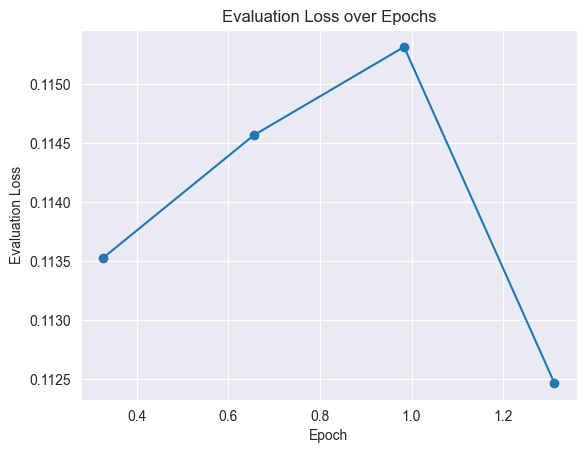

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics for plotting
epochs = [step['epoch'] for step in trainer.state.log_history[:-1] if 'eval_loss' in step]
losses = [step['eval_loss'] for step in trainer.state.log_history[:-1] if 'eval_loss' in step]

# Plotting
plt.plot(epochs, losses, marker='o')
plt.title('Evaluation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Evaluation Loss')

plt.show()

In [ ]:
trainer.evaluate()

{'eval_loss': 0.11246940493583679,
 'eval_runtime': 0.3085,
 'eval_samples_per_second': 350.043,
 'eval_steps_per_second': 6.482,
 'epoch': 1.3114754098360657}

In [ ]:
test_dataset

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 108
})

In [ ]:
id2tag = {id: tag for id, tag in enumerate(merged_tags)}
tag2id = {tag: id for id, tag in id2tag.items()}

In [ ]:

def get_raw_tokens(subtokens: list[str]) -> list[str]:

  tokens = []
  for tok in subtokens:
      if tok.startswith("##"):
          tokens[-1] += tok[2:]
      else:
          tokens.append(tok)
  return tokens

def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, truncation=True, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0][0].softmax(1)
    # executing argmax function to get the candidate tags
    word_ids = inputs.word_ids()
    raw_tokens = get_raw_tokens([tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])][0])[1:-1]
    tags = ([id2tag[x] for x in probs.cpu().detach().numpy().argmax(axis=1).tolist()])
    assert len(word_ids) == len(tags), "ERROR"
    f_tags = []
    for idx in range(len(raw_tokens)):
      f_tags.append(tags[word_ids.index(idx)])


    tokens_n_tags = [(tok,tag) for tok,tag in zip(raw_tokens, f_tags)]

    df_out = pd.DataFrame(tokens_n_tags, columns=['token', 'tag'])
    df_out['id'] = df_out['tag'].map(tag2id)
    return df_out

In [ ]:
test_predictions = []
for test_token, test_tag in zip(tokenized_pos["test"]['tokens'], tokenized_pos["test"]['pos_tags']):
    try:
        prediction = get_prediction(' '.join(test_token))

        # Assuming prediction is a DataFrame or similar structure
        prediction['true_id'] = test_tag
        test_predictions.append(prediction)

    except Exception as e:
        pass

In [ ]:
prediction

,token,tag,id,true_id
0,προτιμω,INTJ,14,14
1,να,NOUN,13,13
2,κρατηθω,INTJ,14,14
3,σ,ADJ,1,1
4,το,VERB,5,5
5,γενικως,PUNCT,2,2
6,και,AUX,4,4
7,αοριστως,PUNCT,2,2
8,.,CCONJ,12,12


In [ ]:
# Initialize an empty set for unique classes
all_classes = set()

# Iterate through each dataframe to collect unique classes
for df in test_predictions:
    all_classes.update(df['true_id'].unique())
    all_classes.update(df['id'].unique())

# Sort the set to maintain consistent ordering
all_classes = sorted(all_classes)

# Convert the set to a list to ensure indexing consistency
all_classes = list(all_classes)
all_classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

defaultdict(<class 'int'>, {('NUM', 'NUM'): 41, ('NUM', 'ADJ'): 0, ('NUM', 'PUNCT'): 1, ('NUM', 'ADV'): 0, ('NUM', 'AUX'): 0, ('NUM', 'VERB'): 2, ('NUM', 'PRON'): 0, ('NUM', 'SCONJ'): 2, ('NUM', 'PART'): 0, ('NUM', 'ADP'): 0, ('NUM', 'DET'): 0, ('NUM', 'X'): 0, ('NUM', 'CCONJ'): 0, ('NUM', 'NOUN'): 0, ('NUM', 'INTJ'): 1, ('NUM', 'PROPN'): 0, ('ADJ', 'NUM'): 0, ('ADJ', 'ADJ'): 83, ('ADJ', 'PUNCT'): 0, ('ADJ', 'ADV'): 0, ('ADJ', 'AUX'): 0, ('ADJ', 'VERB'): 0, ('ADJ', 'PRON'): 0, ('ADJ', 'SCONJ'): 0, ('ADJ', 'PART'): 0, ('ADJ', 'ADP'): 0, ('ADJ', 'DET'): 0, ('ADJ', 'X'): 0, ('ADJ', 'CCONJ'): 0, ('ADJ', 'NOUN'): 0, ('ADJ', 'INTJ'): 0, ('ADJ', 'PROPN'): 0, ('PUNCT', 'NUM'): 0, ('PUNCT', 'ADJ'): 0, ('PUNCT', 'PUNCT'): 64, ('PUNCT', 'ADV'): 0, ('PUNCT', 'AUX'): 0, ('PUNCT', 'VERB'): 0, ('PUNCT', 'PRON'): 0, ('PUNCT', 'SCONJ'): 0, ('PUNCT', 'PART'): 0, ('PUNCT', 'ADP'): 0, ('PUNCT', 'DET'): 0, ('PUNCT', 'X'): 0, ('PUNCT', 'CCONJ'): 0, ('PUNCT', 'NOUN'): 1, ('PUNCT', 'INTJ'): 0, ('PUNCT', 'PROP

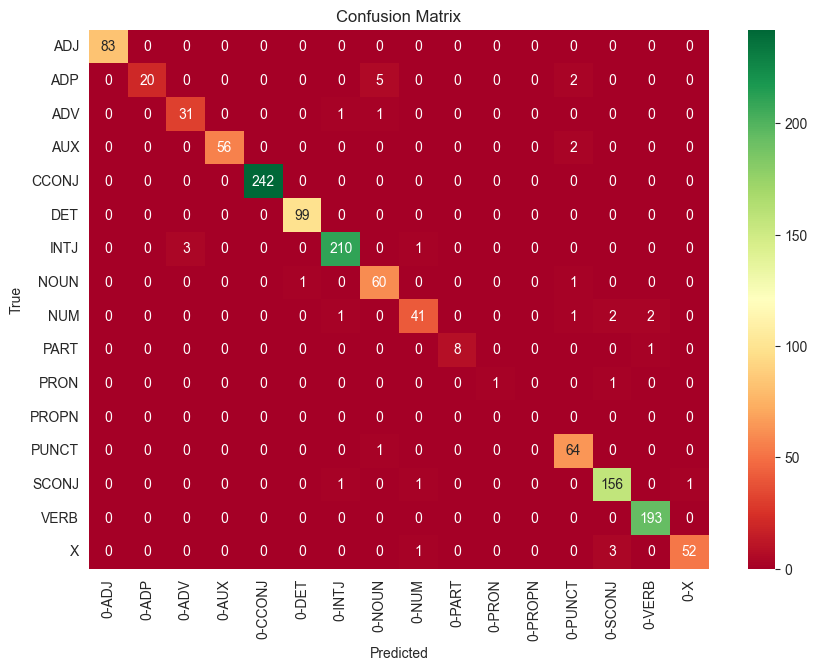

In [ ]:
from collections import defaultdict
import seaborn as sns
# Assuming tag2id is a function that maps a tag to its corresponding id
# and test_predictions is a list of data frames or similar iterable objects

confusion_matrix_res = defaultdict(int)

for class_1 in id2tag.values():
    for class_2 in id2tag.values():  # iterate through rows of the prediction dataframe

        confusion_matrix_res[(class_1, class_2)] = 0

for pred in test_predictions:
    for index, row in pred.iterrows():  # iterate through rows of the prediction dataframe
        pred_tag = row['tag']  # predicted tag

        true_tag = id2tag[row['true_id']]# true tag, assuming 'true_tag' is the column name
        confusion_matrix_res[(true_tag, pred_tag)] += 1

# Print or use confusion_matrix_res as needed
print(confusion_matrix_res)


# Convert confusion matrix to DataFrame for seaborn heatmap
df_cm = pd.DataFrame(confusion_matrix_res.values(), index=pd.MultiIndex.from_tuples(confusion_matrix_res.keys()))

# Reshape the dataframe to have a matrix format
confusion_matrix = df_cm.unstack().fillna(0)


# Plot the confusion matrix with a red to green palette
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, cmap='RdYlGn', fmt='g')  # Adjusted colormap to RdYlGn
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Example #1
text1 = """Αυτό ειναι μια πρόταση."""

display(get_prediction(text1))

,token,tag
0,αυτο,NUM
1,ειναι,PART
2,μια,NUM
3,προταση,PROPN
4,.,NOUN


In [ ]:
# Example #1
text2 = """Δεν πήγα ποτε να δώσω αυτό το μάθημα γιατι δεν είχα χρόνο."""

display(get_prediction(text2))

,token,tag
0,δεν,AUX
1,πηγα,INTJ
2,ποτε,PUNCT
3,να,ADP
4,δωσω,INTJ
5,αυτο,NUM
6,το,NUM
7,μαθημα,PROPN
8,γιατι,ADP
9,δεν,AUX


## Usage of LLM

- Here we check how prompting can be used to generate a response from a pre-trained LLM model.
- We will use the Phi-3-mini-128k-instruct model for this example.

In [ ]:
dir_loc = "C://Users//jason//Documents//coding_repos//chatbot_app//backend//llm_models//Phi-3-mini-128k-instruct"

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(dir_loc, device_map="cuda", torch_dtype="auto", trust_remote_code=True)

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(dir_loc)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
input_sentence = "What Is the purpose of this example?"

prompt_to_classify_words = f"""Given a sentence as input, return the corresponding Part-of-Speech (POS) tags for each word in the sentence and also comma separate each tag. Return only a list with the tags.

The available tags are:
- CCONJ: Coordinating conjunction
- ADV: Adverb
- PUNCT: Punctuation
- PART: Particle
- DET: Determiner
- NUM: Numeral
- X: Other
- PROPN: Proper noun
- SCONJ: Subordinating conjunction
- AUX: Auxiliary
- PRON: Pronoun
- VERB: Verb
- NOUN: Noun
- ADP: Adposition
- INTJ: Interjection
- ADJ: Adjective

Examples:
1. Input: "The quick brown fox jumps over the lazy dog."
   Result: ["DET", "ADJ", "ADJ", "NOUN", "VERB", "ADP", "DET", "ADJ", "NOUN", "PUNCT"]

2. Input: "She sells seashells by the seashore."
   Result: ["PRON", "VERB", "NOUN", "ADP", "DET", "NOUN", "PUNCT"]

3. Input: "The cat sat on the mat."
   Result: ["DET", "NOUN", "VERB", "ADP", "DET", "NOUN", "PUNCT"]

4. Input: "He quickly ran to catch the bus."
   Result: ["PRON", "ADV", "VERB", "PART", "VERB", "DET", "NOUN", "PUNCT"]

5. Input: "The old, sturdy oak tree stood tall."
   Result: ["DET", "ADJ", "PUNCT", "ADJ", "ADJ", "NOUN", "VERB", "ADJ", "PUNCT"]

Please provide the list of tags for the following sentence: "{input_sentence}"
"""


In [ ]:
messages = [
    {"role": "system", "content": prompt_to_classify_words},
]

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 1000,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

["SCONJ", "PROPN", "AUX", "VERB", "DET", "NOUN", "ADP", "DET", "NOUN", "PUNCT"]


In [ ]:
import ast

# Use ast.literal_eval to convert the string to a list
parsed_list = ast.literal_eval(output[0]['generated_text'])

print(parsed_list, type(parsed_list))


['SCONJ', 'PROPN', 'AUX', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PUNCT'] <class 'list'>


In [ ]:
messages = [
    {"role": "system", "content": prompt_to_classify_words},
]

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

C:\Users\jason\miniconda3\envs\chatbot\Lib\site-packages\transformers\generation\configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
input_sentence = "Fly await to the moon."

prompt_to_classify_words = f"""Given a sentence as input, return the corresponding Part-of-Speech (POS) tags for each word in the sentence and also comma separate each tag. Return only a list with the tags.

The available tags are:
- CCONJ: Coordinating conjunction
- ADV: Adverb
- PUNCT: Punctuation
- PART: Particle
- DET: Determiner
- NUM: Numeral
- X: Other
- PROPN: Proper noun
- SCONJ: Subordinating conjunction
- AUX: Auxiliary
- PRON: Pronoun
- VERB: Verb
- NOUN: Noun
- ADP: Adposition
- INTJ: Interjection
- ADJ: Adjective

Examples:
1. Input: "The quick brown fox jumps over the lazy dog."
   Result: ["DET", "ADJ", "ADJ", "NOUN", "VERB", "ADP", "DET", "ADJ", "NOUN", "PUNCT"]

2. Input: "She sells seashells by the seashore."
   Result: ["PRON", "VERB", "NOUN", "ADP", "DET", "NOUN", "PUNCT"]

3. Input: "The cat sat on the mat."
   Result: ["DET", "NOUN", "VERB", "ADP", "DET", "NOUN", "PUNCT"]

4. Input: "He quickly ran to catch the bus."
   Result: ["PRON", "ADV", "VERB", "PART", "VERB", "DET", "NOUN", "PUNCT"]

5. Input: "The old, sturdy oak tree stood tall."
   Result: ["DET", "ADJ", "PUNCT", "ADJ", "ADJ", "NOUN", "VERB", "ADJ", "PUNCT"]

Please provide the list of tags for the following sentence: "{input_sentence}"
"""


messages = [
    {"role": "system", "content": prompt_to_classify_words},
]

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.1,
    "do_sample": False,
}

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

["VERB", "AUX", "PART", "DET", "NOUN"]
